In [2]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_surf_stat_map
from matplotlib import pyplot as plt
import pandas as pd

/home/fralberti/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


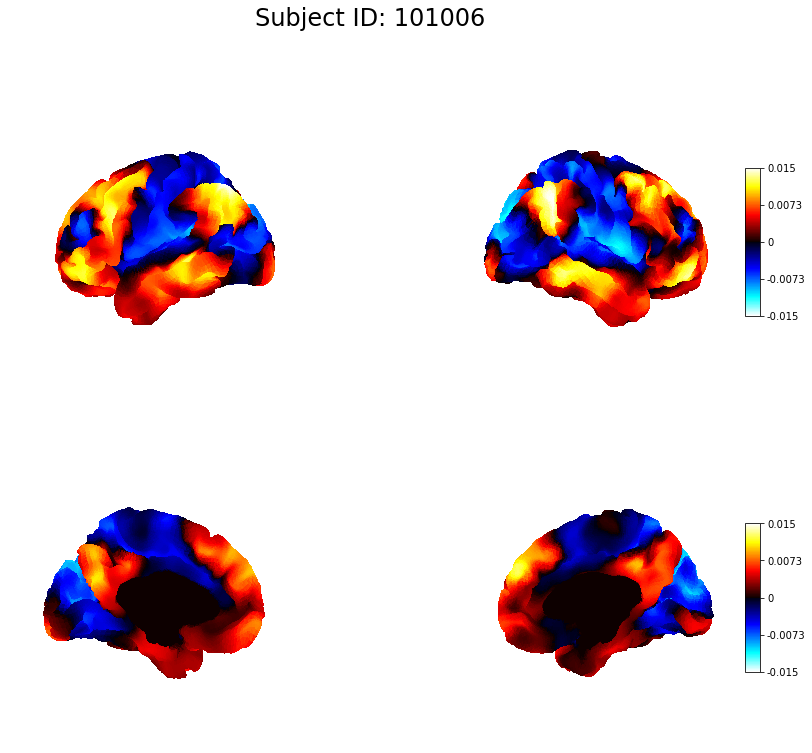

In [16]:
### Visualize individual gradients

subjs_to_plot = [101006]

for subj in subjs_to_plot:
    grad1 = nib.load(f'/home/fralberti/Data/HCP_func/Pctile_output/{subj}_gcca.dscalar.nii')
    fig, axs = plt.subplots(2, 2, figsize=(15,12), subplot_kw={'projection':'3d'}, sharey=True)
    
    for i, hemi in enumerate(['L','R']):
        hemisphere = ['left','right']
        surf = nib.load(f'/home/fralberti/Data/HCP_zone_prim/{subj}/{subj}.{hemi}.midthickness_MSMAll.32k_fs_LR.surf.gii')
        
        idx_count = grad1.header.get_index_map(1)[i].index_count
        idx_offset = grad1.header.get_index_map(1)[i].index_offset
        vtx_indices = grad1.header.get_index_map(1)[i].vertex_indices[0:]
        stat_map = np.zeros(surf.agg_data()[0].shape[0])
        stat_map[vtx_indices] = np.asanyarray(grad1.get_fdata()[0].squeeze()[idx_offset:idx_offset+idx_count])

        plot_surf_stat_map(f'/home/fralberti/Data/HCP_zone_prim/{subj}/{subj}.{hemi}.midthickness_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], axes=axs[0,i],colorbar=i)
        plot_surf_stat_map(f'/home/fralberti/Data/HCP_zone_prim/{subj}/{subj}.{hemi}.midthickness_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], view='medial', axes=axs[1,i],colorbar=i)
        fig.suptitle('Subject ID: %s' % subj, fontsize=24)
                
        del surf
    del grad1


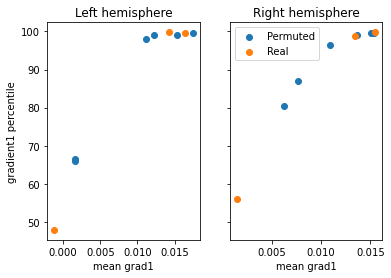

In [12]:
### Visualize real and null gradient percentiles

output_dir = "/home/fralberti/Data/HCP_func/Pctile_output/"

gradientile_df = pd.read_csv(f'{output_dir}grad1entiles.csv')
perm_percentile_L = gradientile_df.loc[(gradientile_df.ID_vtx!=gradientile_df.ID_grad) & (gradientile_df.hemisphere=='L'),['mean','percentile']]
orig_percentile_L = gradientile_df.loc[(gradientile_df.ID_vtx==gradientile_df.ID_grad) & (gradientile_df.hemisphere=='L'),['mean','percentile']]
perm_percentile_R = gradientile_df.loc[(gradientile_df.ID_vtx!=gradientile_df.ID_grad) & (gradientile_df.hemisphere=='R'),['mean','percentile']]
orig_percentile_R = gradientile_df.loc[(gradientile_df.ID_vtx==gradientile_df.ID_grad) & (gradientile_df.hemisphere=='R'),['mean','percentile']]

fig1 , ax1 = plt.subplots(1,2,sharey=True)

ax1[0].scatter(perm_percentile_L['mean'], perm_percentile_L['percentile'])
ax1[0].scatter(orig_percentile_L['mean'], orig_percentile_L['percentile'])
ax1[0].set_xlabel('mean grad1')
ax1[0].set_ylabel('gradient1 percentile')
ax1[0].title.set_text('Left hemisphere')

ax1[1].scatter(perm_percentile_R['mean'], perm_percentile_R['percentile'])
ax1[1].scatter(orig_percentile_R['mean'], orig_percentile_R['percentile'])
ax1[1].set_xlabel('mean grad1')
ax1[1].legend(['Permuted','Real'])
ax1[1].title.set_text('Right hemisphere')

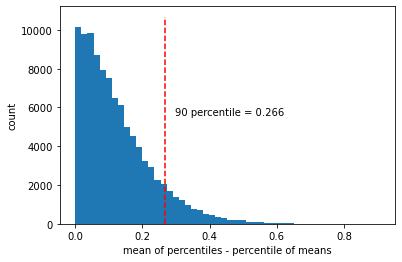

In [15]:
### Visualize difference between percentile of the mean grad1 vs the mean of the percentiles of each node
from scipy import stats
diff = []
for i in range(100000):
    X = np.random.uniform(low=-0.022, high=0.022,size=[32000])
    x = np.random.uniform(low=-0.022, high=0.022,size=[3])
    diff.append(abs(np.mean([stats.percentileofscore(X,i) for i in x])-stats.percentileofscore(X,np.mean(x))))

perc = 90
plot=plt.hist(diff,50)
np.percentile(diff,perc)
plot = plt.vlines(np.percentile(diff,perc),plt.ylim()[0],plt.ylim()[1],'r','--')
plot = plt.text(np.percentile(diff,perc)+0.03,plt.ylim()[1]/2,f'{perc} percentile = {np.percentile(diff,perc).round(3)}')
plot = plt.ylabel('count')
plot = plt.xlabel('mean of percentiles - percentile of means')
